# Housing value prediction

### Imports

In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from pandas.plotting import scatter_matrix

### A quick look at the data



In [14]:
housing_df = pd.read_csv('~/work/data/housing.csv')
housing = housing_df.copy()

display(housing_df.head())
display(housing_df.info())
display(housing_df.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


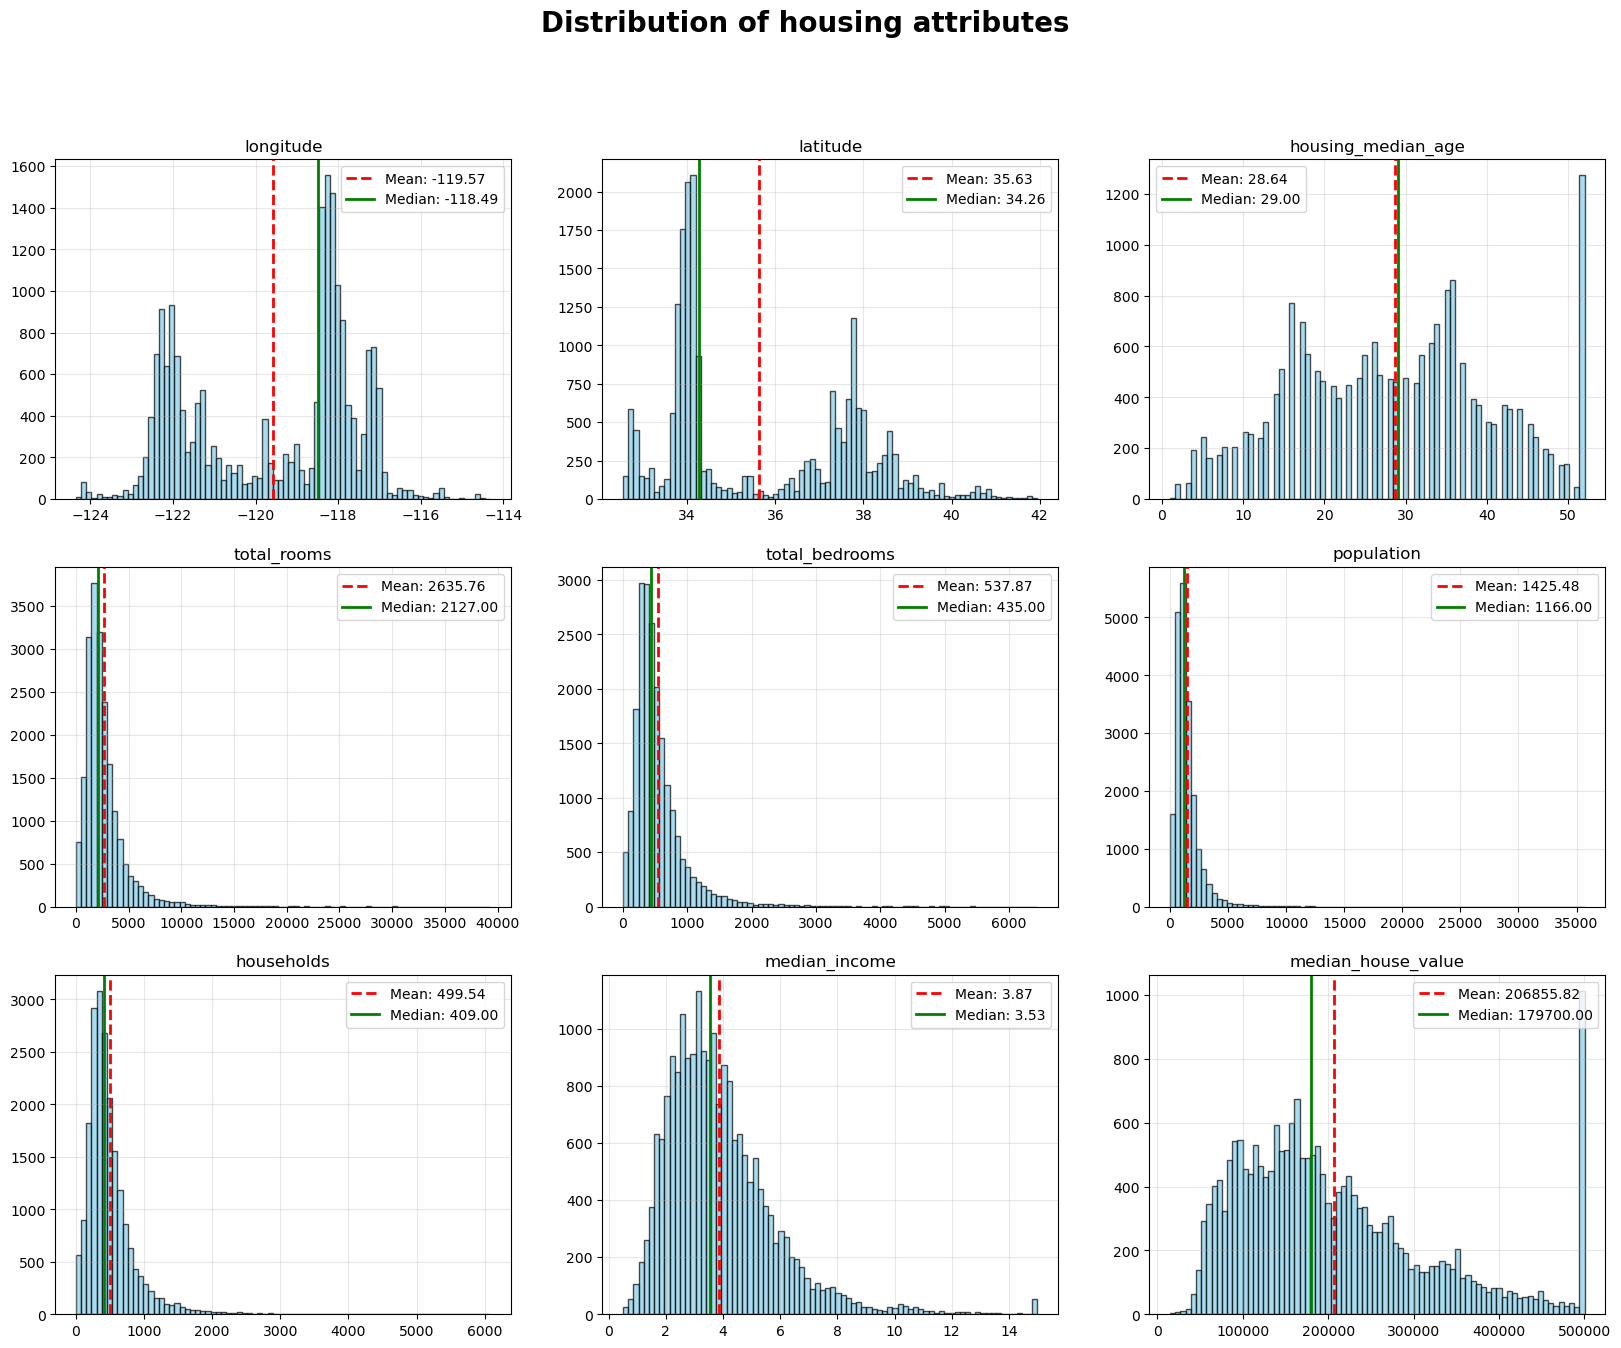

In [15]:
# A cell with Gemini would offer AI assistance like code generation, completion, or explanations.
# This is a standard code cell without such active AI features in this context.
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()  # Flatten for easy indexing

fig.suptitle('Distribution of housing attributes', fontsize=20, fontweight='bold')
for i, column in enumerate(housing_df.columns):
    if i < len(axes):  # Ensure we don't exceed subplot count
        # Plot histogram
        axes[i].hist(housing_df[column].dropna(), bins=80, alpha=0.7, color='skyblue', edgecolor='black')

        # Calculate and plot mean and median
        mean_val = housing_df[column].mean()
        median_val = housing_df[column].median()

        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

        axes[i].set_title(column)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.show()

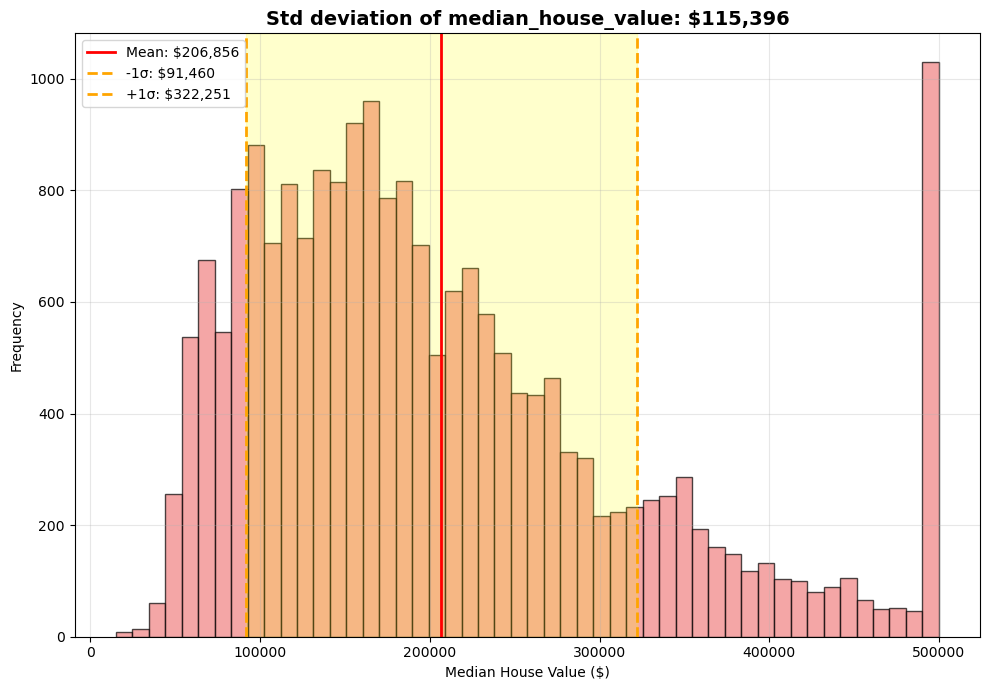

In [16]:
std_stats = housing["median_house_value"].std()
mean_price = housing["median_house_value"].mean()
median_price = housing["median_house_value"].median()

fig, ax = plt.subplots(figsize=(10, 7))

house_values = housing['median_house_value']
ax.hist(house_values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')

ax.axvline(mean_price, color='red', linestyle='-', linewidth=2,label=f'Mean: ${mean_price:,.0f}')
ax.axvline(mean_price - std_stats, color='orange', linestyle='--', linewidth=2, label=f'-1σ: ${mean_price - std_stats:,.0f}')
ax.axvline(mean_price + std_stats, color='orange', linestyle='--', linewidth=2, label=f'+1σ: ${mean_price + std_stats:,.0f}')
ax.axvspan(mean_price - std_stats, mean_price + std_stats, alpha=0.2, color='yellow')

ax.set_title(f'Std deviation of median_house_value: ${std_stats:,.0f}',fontweight='bold', fontsize=14)

ax.set_xlabel('Median House Value ($)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Create income category

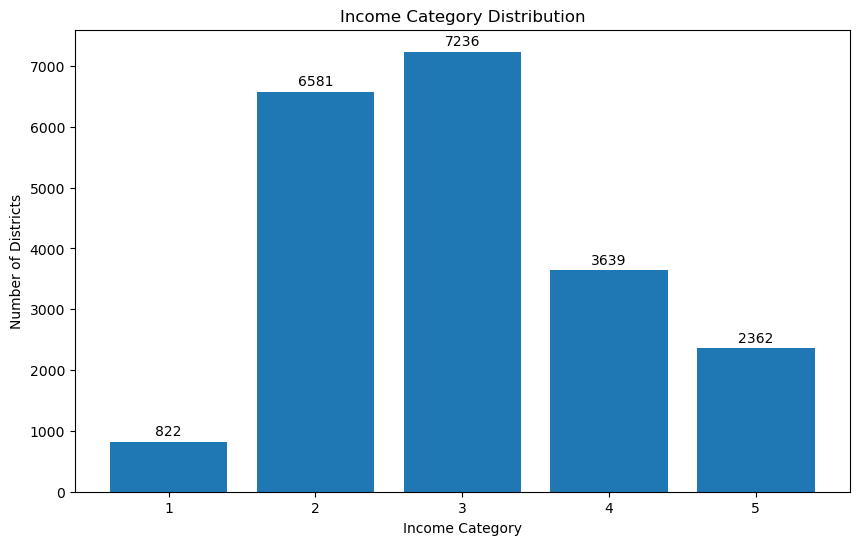

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=["1", "2", "3", "4", "5"])
income_counts = housing["income_cat"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(income_counts)), income_counts.values)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,f'{int(height)}', ha='center', va='bottom')

plt.xticks(range(len(income_counts)), ["1", "2", "3", "4", "5"])
plt.ylabel('Number of Districts')
plt.xlabel('Income Category')
plt.title('Income Category Distribution')
plt.show()


### Create stratified sets

In [18]:
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_splitter.split(housing, housing["income_cat"]):

    stratified_train_set = housing.loc[train_index].copy()
    stratified_test_set = housing.loc[test_index].copy()

    print(stratified_train_set["income_cat"].value_counts() / len(stratified_train_set))
    print(stratified_test_set["income_cat"].value_counts() / len(stratified_test_set))

stratified_train_set = stratified_train_set.drop("income_cat", axis=1)
stratified_test_set = stratified_test_set.drop("income_cat", axis=1)

housing = stratified_train_set.copy()

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


### Visualize geographic data

<Axes: xlabel='longitude', ylabel='latitude'>

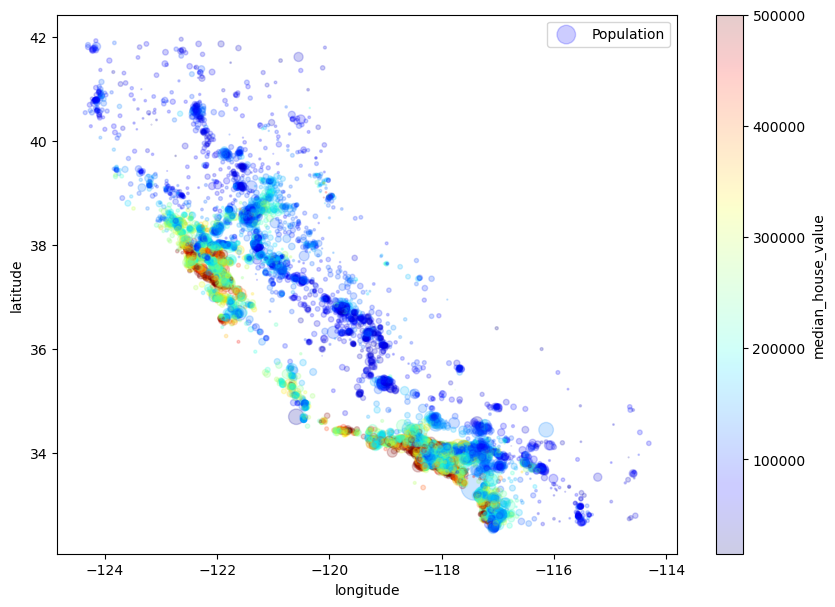

In [19]:
housing.plot(
kind="scatter",
x="longitude",
y="latitude",
alpha=0.2,
s=housing["population"]/100,
label="Population",
figsize=(10, 7),
c="median_house_value",
cmap=plt.get_cmap("jet"),
colorbar=True
)

### Analize correlations

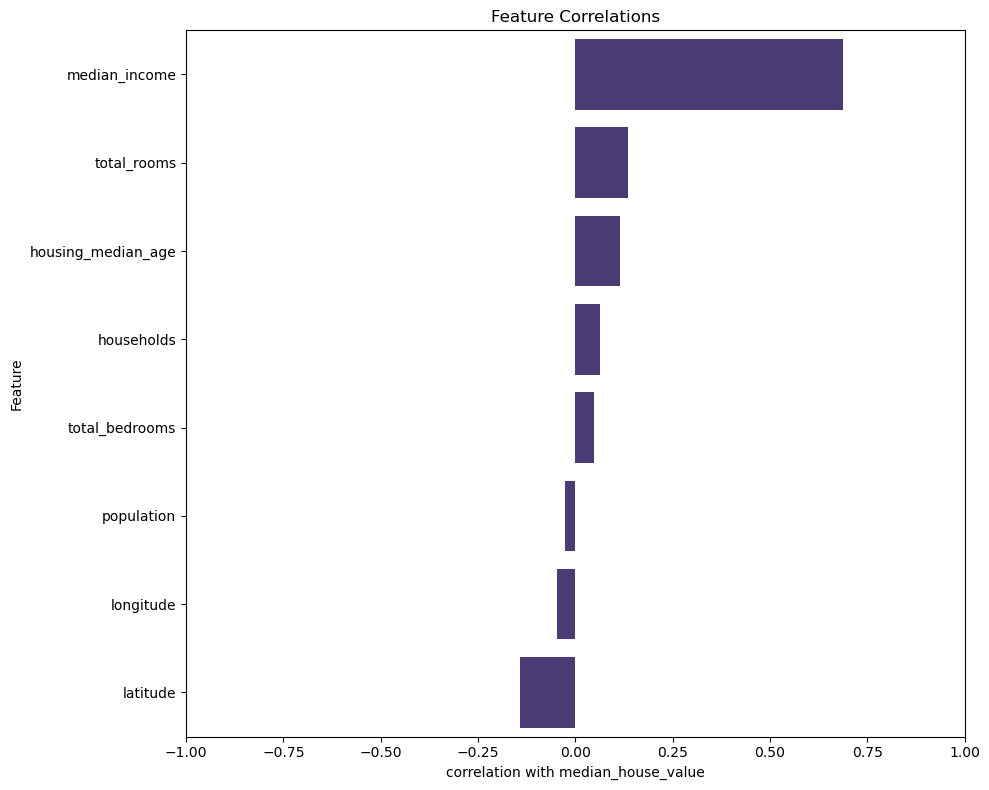

In [20]:
corr_matrix = housing.corr(numeric_only=True)
target = "median_house_value"
corr_target = corr_matrix[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_target.values,y=corr_target.index,color=sns.color_palette("viridis")[0])
plt.xlabel(f"correlation with {target}")
plt.ylabel("Feature")
plt.title("Feature Correlations")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

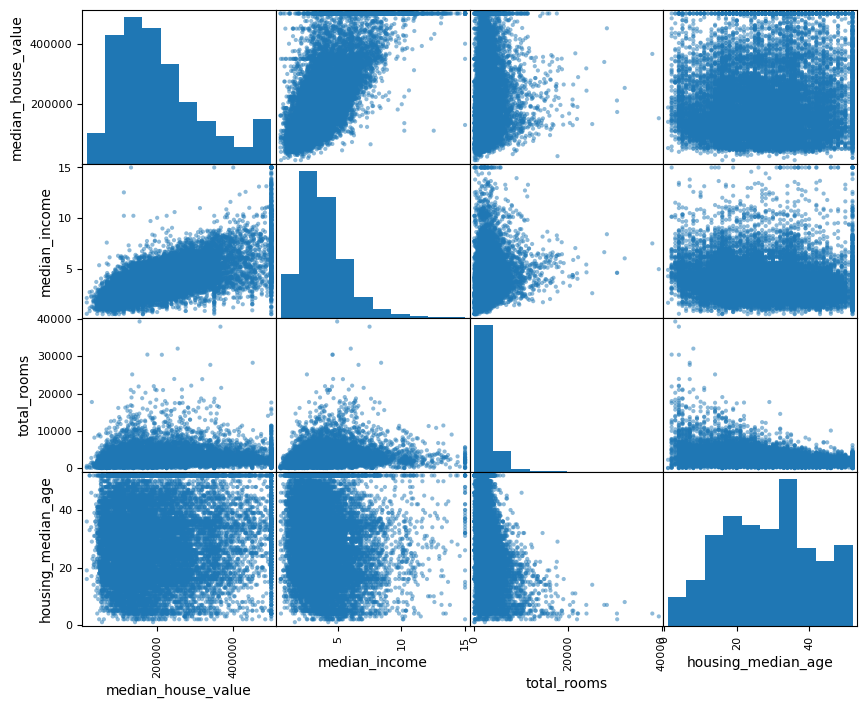

In [21]:
attrs = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attrs], figsize=(10, 8))
plt.show()

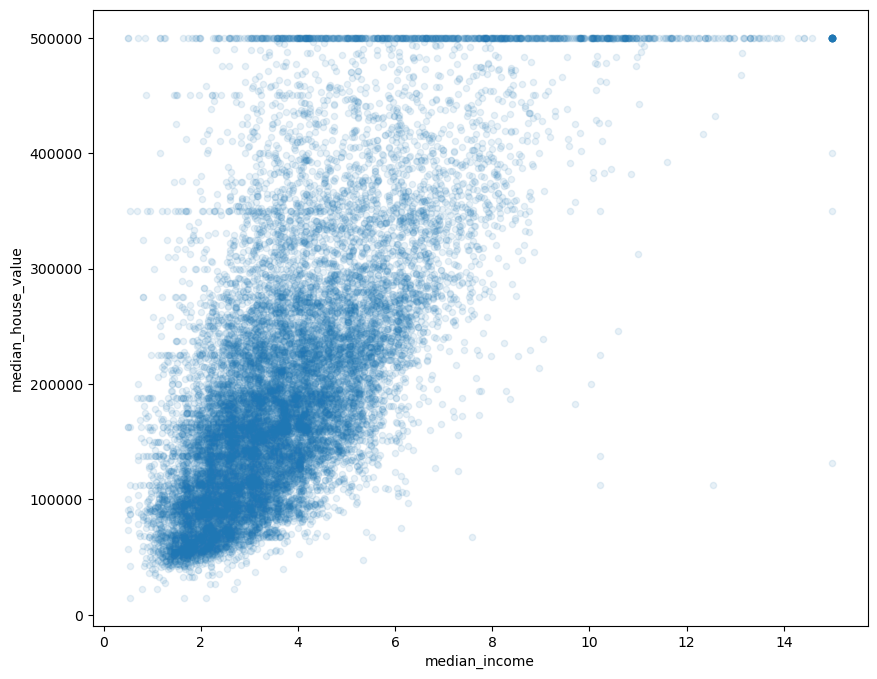

In [22]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10, 8))
plt.show()

### Analize correlations with combined features

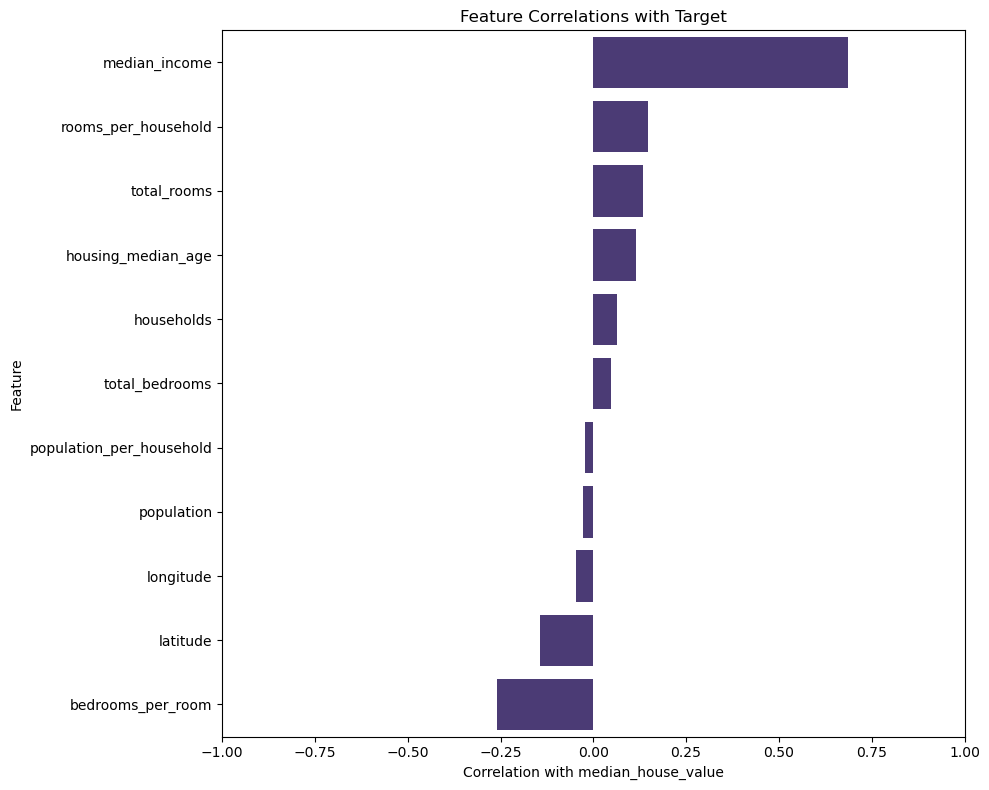

In [23]:
housing_with_combined_features = housing.copy()

housing_with_combined_features["rooms_per_household"] = housing_with_combined_features["total_rooms"] / housing_with_combined_features["households"]
housing_with_combined_features["bedrooms_per_room"] = housing_with_combined_features["total_bedrooms"] / housing_with_combined_features["total_rooms"]
housing_with_combined_features["population_per_household"] = housing_with_combined_features["population"] / housing_with_combined_features["households"]

target = "median_house_value"
corr_matrix = housing_with_combined_features.corr(numeric_only=True)
corr_matrix[target].sort_values(ascending=False)
corr_target = corr_matrix[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_target.values,y=corr_target.index,color=sns.color_palette("viridis")[0])
plt.xlabel(f"Correlation with {target}")
plt.ylabel("Feature")
plt.title("Feature Correlations with Target")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

### Implement pipelines

In [24]:
num_attrs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms','population', 'households','median_income']
cat_attrs = ["ocean_proximity"]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        num_attrs=num_attrs,
        add_bedrooms_per_room=True,
        rooms_col='total_rooms',
        bedrooms_col='total_bedrooms',
        population_col='population',
        households_col='households'
    ):
        self.num_attrs = num_attrs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_col = rooms_col
        self.bedrooms_col = bedrooms_col
        self.population_col = population_col
        self.households_col = households_col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            if X.ndim == 1:
                X_df = pd.DataFrame([X], columns=self.num_attrs)
            else:
                X_df = pd.DataFrame(X, columns=self.num_attrs)
        else:
            X_df = X
        X_out = X_df.copy()
        X_out['rooms_per_household'] = X_out[self.rooms_col] / X_out[self.households_col]
        X_out['population_per_household'] = X_out[self.population_col] / X_out[self.households_col]

        if self.add_bedrooms_per_room:
            X_out['bedrooms_per_room'] = X_out[self.bedrooms_col] / X_out[self.rooms_col]
        return X_out

num_column_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_column_pipeline, num_attrs),
    ('cat', OneHotEncoder(), cat_attrs),

])

### Train and evaluate models

In [25]:
housing = stratified_train_set.drop("median_house_value", axis=1)
housing_labels = stratified_train_set["median_house_value"].copy()

housing_prepared = full_pipeline.fit_transform(housing)

Linear regression

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_reg_mse = mean_squared_error(housing_labels, housing_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

print("=== Linear Regression ===")
print("RMSE:", lin_reg_rmse)

print("\n === Cross-Validation ===")
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-scores)
print("Scores:", lin_reg_rmse_scores)
print("Mean:", lin_reg_rmse_scores.mean())
print("Std:", lin_reg_rmse_scores.std())

=== Linear Regression ===
RMSE: 68633.40810776998

 === Cross-Validation ===
Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean: 69116.4347200802
Std: 2880.6588594759014


Decission tree

In [27]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print("\n ==== Decision Tree Regressor ====")
print("RMSE:", tree_rmse)


print("\n === Cross-Validation ===")
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Scores:", tree_rmse_scores)
print("Mean:", tree_rmse_scores.mean())
print("Std:", tree_rmse_scores.std())


 ==== Decision Tree Regressor ====
RMSE: 0.0

 === Cross-Validation ===
Scores: [72803.38175746 70433.36448275 68479.88437274 71837.50377625
 71259.26543033 76660.46864184 71928.228762   72942.41927478
 68672.83741997 70840.59420842]
Mean: 71585.79481265352
Std: 2222.1143593363427


Random forest

In [28]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print("\n === Random Forest Regressor ===")
print("RMSE:", forest_rmse)

print("\n === Random Forest Regressor Cross-Validation ===")
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
print("Scores:", forest_rmse_scores)
print("Mean:", forest_rmse_scores.mean())
print("Std:", forest_rmse_scores.std())


 === Random Forest Regressor ===
RMSE: 18695.637416837588

 === Random Forest Regressor Cross-Validation ===
Scores: [51300.99460954 49141.21909626 47134.32551079 51929.90730217
 47514.46850709 51327.80202626 52377.45457512 49834.52061857
 48402.46258438 54092.90513915]
Mean: 50305.60599693157
Std: 2153.0761902961817


### Tuning hyperparameters

In [29]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Best params and estimator

In [30]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30)


Feaure importance

In [31]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
numeric_attrs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms','population', 'households','median_income']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = numeric_attrs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.358484768807129, 'median_income'),
 (0.1513186292373035, 'INLAND'),
 (0.10498239240122102, 'pop_per_hhold'),
 (0.07227421523785243, 'longitude'),
 (0.06783282349443609, 'bedrooms_per_room'),
 (0.06271720707096991, 'latitude'),
 (0.052087357906809406, 'rooms_per_hhold'),
 (0.041909594480854545, 'housing_median_age'),
 (0.019063156014360053, 'total_rooms'),
 (0.018160638284046546, 'population'),
 (0.01673577947636929, 'households'),
 (0.01614883222996538, 'total_bedrooms'),
 (0.010885698299461533, '<1H OCEAN'),
 (0.004320690838356337, 'NEAR OCEAN'),
 (0.002996326565317725, 'NEAR BAY'),
 (8.188965554732198e-05, 'ISLAND')]

Scores


In [32]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63417.702483991685 {'max_features': 2, 'n_estimators': 3}
55497.59897869421 {'max_features': 2, 'n_estimators': 10}
52686.95421735595 {'max_features': 2, 'n_estimators': 30}
60597.06799502204 {'max_features': 4, 'n_estimators': 3}
52542.192878094975 {'max_features': 4, 'n_estimators': 10}
50431.522418056724 {'max_features': 4, 'n_estimators': 30}
59040.84180589134 {'max_features': 6, 'n_estimators': 3}
52676.49854743829 {'max_features': 6, 'n_estimators': 10}
49681.25501413026 {'max_features': 6, 'n_estimators': 30}
59887.44733211473 {'max_features': 8, 'n_estimators': 3}
52322.31741081333 {'max_features': 8, 'n_estimators': 10}
50193.17948516963 {'max_features': 8, 'n_estimators': 30}
62562.251120516674 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54379.2936640054 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60889.66701658158 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52929.786483569995 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### Model



In [33]:
model  = grid_search.best_estimator_
X_test = stratified_test_set.drop("median_house_value", axis=1)
y_test = stratified_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

### Predictions

In [34]:
final_predictions = model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48311.44482271624
